Enable auto-reloading of external modules

In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sys import getsizeof

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *

import warnings
warnings.filterwarnings('ignore')

SEED=10
plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
# figure size in inches
rcParams['figure.figsize'] = 8, 8
sns.set_style("darkgrid")

In [92]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment
    # clear_output()

### Loading ACSEmployment data

In [93]:
config = {
    'state': ["CA"],
    'year': '2016',
    'task': ACSEmployment
}

In [94]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [95]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 45 mb
Optimized: 23 mb


#### Checking if there are nulls in the dataset

In [96]:
X_data.isnull().sum()

AGEP             0
SCHL         11466
MAR              0
RELP             0
DIS              0
ESP         300716
CIT              0
MIG           3702
MIL          74731
ANC              0
NATIVITY         0
DEAR             0
DEYE             0
DREM         19605
SEX              0
RAC1P            0
dtype: int64

### Preprocessing: Handling nulls

In [97]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']

In [98]:
handle_nulls = {
    'special': ['SCHL','MIG', 'MIL', 'DREM', 'ESP'],
}

In [99]:
# Checking dataset shape before handling nulls
X_data.shape, X_data.columns

((376035, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

In [100]:
for how_to in handle_nulls.keys():
    X_data = handle_df_nulls(X_data, how_to, handle_nulls[how_to])

Impute values:  {'SCHL': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0, 'ESP': 0}


In [101]:
#Checking dataset shape after handling nulls
X_data.shape, X_data.columns

((376035, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

#### Rechecking if there are nulls -- if the null_handler has run correctly, there should not be

In [102]:
X_data.isnull().sum()

AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

### Simulate Different Null Scenarios

In [103]:
# Config with simulated scenarios
simulated_scenarios_dict = {
    # "Optional" Type of Nulls
    'MAR': {
        'special_values': [2, 3, 4],
        'condition_col': 'MAR',
        'target_col': 'MAR',
        'fraction': 0.9
    },
    # "Not Applicable" Type of Nulls
    'MIL': {
        'special_values': [i for i in range(0, 17)],
        'condition_col': 'AGEP',
        'target_col': 'MIL',
        'fraction': 0.9
    },
    'SCHL': {
        'special_values': [i for i in range(0, 3)],
        'condition_col': 'AGEP',
        'target_col': 'SCHL',
        'fraction': 0.9
    },
    'ESP': {
        'special_values': [0],
        'condition_col': 'ESP',
        'target_col': 'ESP',
        'fraction': 0.9
    },
    'MIG': {
        'special_values': [0],
        'condition_col': 'AGEP',
        'target_col': 'MIG',
        'fraction': 0.9
    },
    'DREM_not_applic': {
        'special_values': [i for i in range(0, 5)],
        'condition_col': 'AGEP',
        'target_col': 'DREM',
        'fraction': 0.9
    },
    # "Unknown" Type of Nulls
    'AGEP': {
        'special_values': (8, 10, 11, 12, 15),
        'condition_col': 'RELP',
        'target_col': 'AGEP',
        'fraction': 0.9
    },
    'NATIVITY': {
        'special_values': (11, 12, 15),
        'condition_col': 'RELP',
        'target_col': 'NATIVITY',
        'fraction': 0.9
    },
    # "Avoided" Type of Nulls
    'DIS': {
        'special_values': [True],
        'condition_col': 'DIS',
        'target_col': 'DIS',
        'fraction': 0.9
    },
    'DEAR': {
        'special_values': [True],
        'condition_col': 'DEAR',
        'target_col': 'DEAR',
        'fraction': 0.9
    },
    'DEYE': {
        'special_values': [True],
        'condition_col': 'DEYE',
        'target_col': 'DEYE',
        'fraction': 0.9
    },
    'DREM_avoided': {
        'special_values': [True],
        'condition_col': 'DREM',
        'target_col': 'DREM',
        'fraction': 0.9
    },
    # "Special" Type of Nulls
    'SEX': {
        'special_values': [1],
        'condition_col': 'SEX',
        'target_col': 'SEX',
        'fraction': 0.11
    },
    'RAC1P': {
        'special_values': [9],
        'condition_col': 'RAC1P',
        'target_col': 'RAC1P',
        'fraction': 0.9
    },
}

In [104]:
def simulate_scenario(data, simulated_scenario_dict):
    return nulls_simulator(data,
                           simulated_scenario_dict['target_col'],
                           simulated_scenario_dict['condition_col'],
                           simulated_scenario_dict['special_values'],
                           simulated_scenario_dict['fraction'])

In [105]:
# "Optional" Type of Nulls
corrupted_data_MAR = simulate_scenario(X_data, simulated_scenarios_dict['MAR'])

In [106]:
# "Not Applicable" Type of Nulls
corrupted_data_MIL = simulate_scenario(X_data, simulated_scenarios_dict['MIL'])
corrupted_data_SCHL = simulate_scenario(X_data, simulated_scenarios_dict['SCHL'])
corrupted_data_ESP = simulate_scenario(X_data, simulated_scenarios_dict['ESP'])
corrupted_data_MIG = simulate_scenario(X_data, simulated_scenarios_dict['MIG'])
corrupted_data_DREM_not_applic = simulate_scenario(X_data, simulated_scenarios_dict['DREM_not_applic'])

In [107]:
# "Unknown" Type of Nulls
corrupted_data_AGEP = simulate_scenario(X_data, simulated_scenarios_dict['AGEP'])
corrupted_data_NATIVITY = simulate_scenario(X_data, simulated_scenarios_dict['NATIVITY'])

In [108]:
# "Avoided" Type of Nulls
corrupted_data_DIS = simulate_scenario(X_data, simulated_scenarios_dict['DIS'])
corrupted_data_DEAR = simulate_scenario(X_data, simulated_scenarios_dict['DEAR'])
corrupted_data_DEYE = simulate_scenario(X_data, simulated_scenarios_dict['DEYE'])
corrupted_data_DREM_avoided = simulate_scenario(X_data, simulated_scenarios_dict['DREM_avoided'])

In [109]:
# "Special" Type of Nulls
corrupted_data_SEX = simulate_scenario(X_data, simulated_scenarios_dict['SEX'])
corrupted_data_RAC1P = simulate_scenario(X_data, simulated_scenarios_dict['RAC1P'])

## Impute Nulls

In [153]:
def impute_with_all_techniques(corrupted_data, target_column, column_type, enable_plots=True, real_data=X_data):
    if column_type == "categorical":
        # how_to_list = ["drop-column", "drop-rows", "impute-by-mode", "impute-by-mode-trimmed"]
        how_to_list = ["impute-by-mode-conditional", "impute-by-mode-trimmed-conditional"]
    elif column_type == "numerical":
        how_to_list = ["drop-column", "drop-rows", "impute-by-mean", "impute-by-mean-trimmed", "impute-by-median", "impute-by-median-trimmed"]
    else:
        raise ValueError("Incorrect input column_type. It must be in ('categorical', 'numerical')")

    imputed_data_dict = dict()
    for how_to in how_to_list:
        print("\n" * 4, "#" * 15, f" Impute {target_column} column with {how_to} technique ", "#" * 15)
        imputed_data = handle_df_nulls(corrupted_data, how_to, condition_column="RAC1P", column_names=[target_column])
        imputed_data_dict[how_to] = imputed_data
        if enable_plots and how_to != "drop-column":
            imputed_nulls_analysis(real_data, imputed_data, corrupted_data, target_col=target_column)

    return imputed_data_dict

### "Optional" Type of Nulls [MAR column]

In [179]:
new_corrupted_data_MAR = corrupted_data_MAR[~corrupted_data_MAR['MAR'].isnull()][['MAR', 'RAC1P']]
new_corrupted_data_MAR['count'] = new_corrupted_data_MAR.groupby(['MAR', 'RAC1P'])['MAR'].transform('count')
new_corrupted_data_MAR = new_corrupted_data_MAR.drop_duplicates()

In [180]:
new_corrupted_data_MAR['count_max'] = new_corrupted_data_MAR.groupby(['RAC1P'])['count'].transform(max)
# new_corrupted_data_MAR.drop(columns=['count'], axis=1, inplace=True)
new_corrupted_data_MAR[new_corrupted_data_MAR.count == new_corrupted_data_MAR.count_max]

,MAR,RAC1P,count,count_max


In [193]:
new_corrupted_data_MAR = corrupted_data_MAR[~corrupted_data_MAR['MAR'].isnull()][['MAR', 'RAC1P']]
counts_df = new_corrupted_data_MAR[new_corrupted_data_MAR['RAC1P'] == 1]['MAR'].value_counts()
# col_value = counts_df.index[0]
# counts = counts_df[0]
counts_df.index[0], counts_df.iloc[0]

(1.0, 99041)

In [200]:
mapping_dict = dict()
condition_column = 'RAC1P'
target_column = 'MAR'
new_corrupted_data_MAR = corrupted_data_MAR[~corrupted_data_MAR[target_column].isnull()][[target_column, condition_column]]
for val in new_corrupted_data_MAR[condition_column].unique():
    counts_df = new_corrupted_data_MAR[new_corrupted_data_MAR[condition_column] == val][target_column].value_counts()
    mapping_dict[f"{condition_column}-{val}"] = counts_df.iloc[0], f'{target_column}-{counts_df.index[0]}'

In [201]:
mapping_dict

{'RAC1P-9': (12147, 'MAR-5.0'),
 'RAC1P-1': (99041, 'MAR-1.0'),
 'RAC1P-8': (26025, 'MAR-5.0'),
 'RAC1P-2': (10176, 'MAR-5.0'),
 'RAC1P-3': (1326, 'MAR-5.0'),
 'RAC1P-6': (27844, 'MAR-1.0'),
 'RAC1P-5': (452, 'MAR-5.0'),
 'RAC1P-7': (639, 'MAR-5.0'),
 'RAC1P-4': (17, 'MAR-5.0')}





 ###############  Impute MAR column with impute-by-mode-conditional technique  ###############
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 5.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  47040
Number of nulls in MAR column in the imputed dataframe:  0


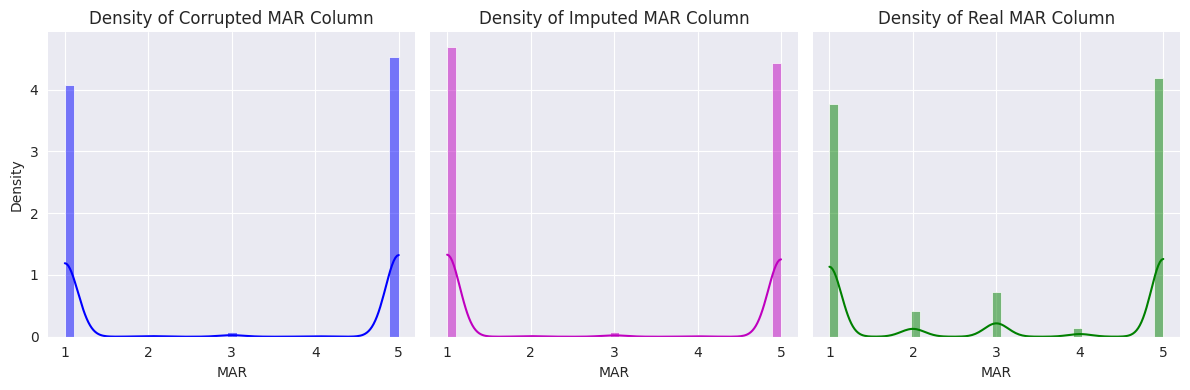





 ###############  Impute MAR column with impute-by-mode-trimmed-conditional technique  ###############
Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 5.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  47040
Number of nulls in MAR column in the imputed dataframe:  0


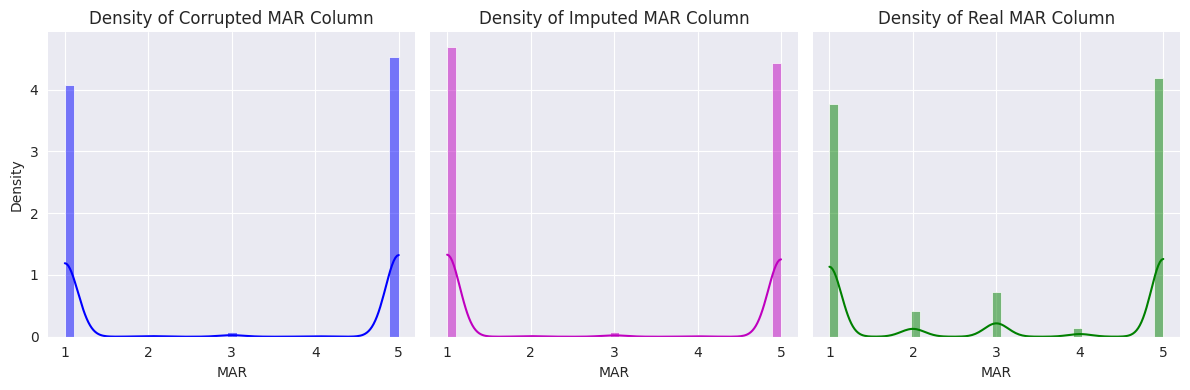

In [154]:
imputed_data_dict_MAR = impute_with_all_techniques(corrupted_data_MAR, target_column="MAR", column_type="categorical")

### "Not Applicable" Type of Nulls

#### MIL Column





 ###############  Impute MIL column with drop-column technique  ###############




 ###############  Impute MIL column with drop-rows technique  ###############
Number of nulls in MIL column in the corrupted dataframe:  67257
Number of nulls in MIL column in the imputed dataframe:  0


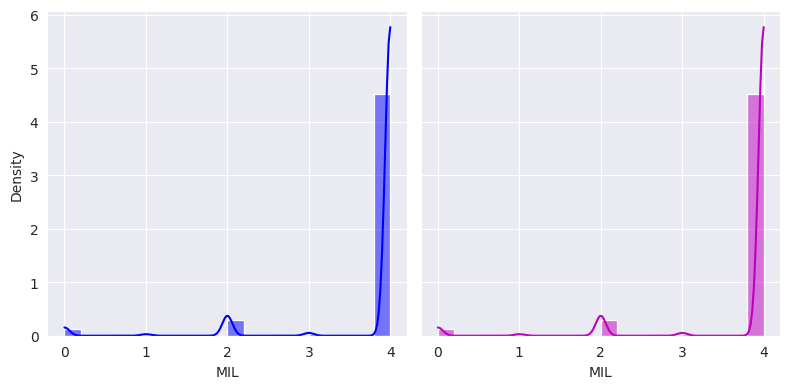





 ###############  Impute MIL column with impute-by-mode technique  ###############
Impute values:  {'MIL': 4.0}
Number of nulls in MIL column in the corrupted dataframe:  67257
Number of nulls in MIL column in the imputed dataframe:  0


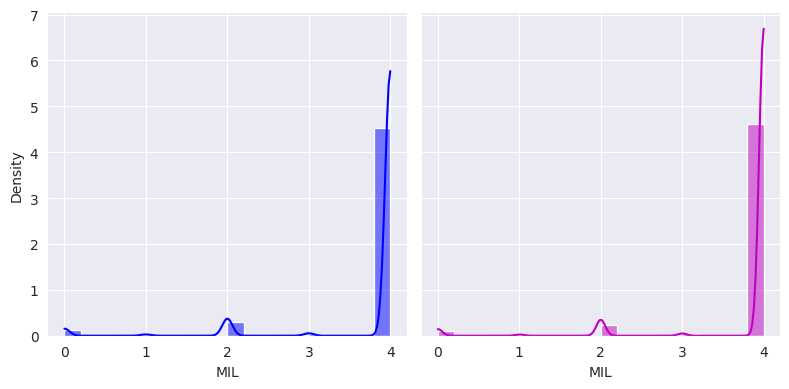





 ###############  Impute MIL column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MIL': 4.0}
Number of nulls in MIL column in the corrupted dataframe:  67257
Number of nulls in MIL column in the imputed dataframe:  0


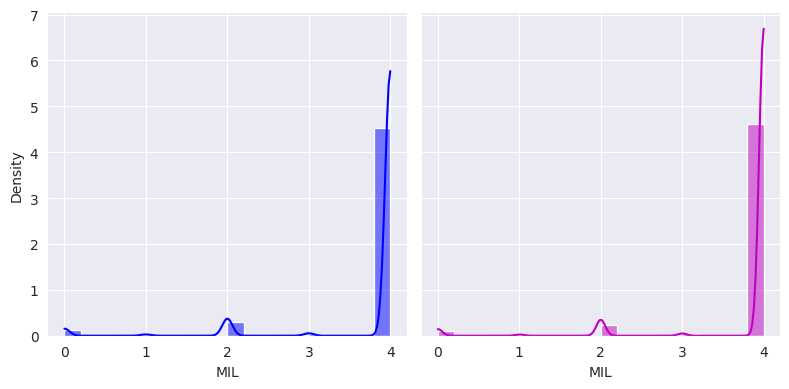

In [112]:
imputed_data_dict_MIL = impute_with_all_techniques(corrupted_data_MIL, target_column="MIL", column_type="categorical")

#### SCHL Column





 ###############  Impute SCHL column with drop-column technique  ###############




 ###############  Impute SCHL column with drop-rows technique  ###############
Number of nulls in SCHL column in the corrupted dataframe:  10319
Number of nulls in SCHL column in the imputed dataframe:  0


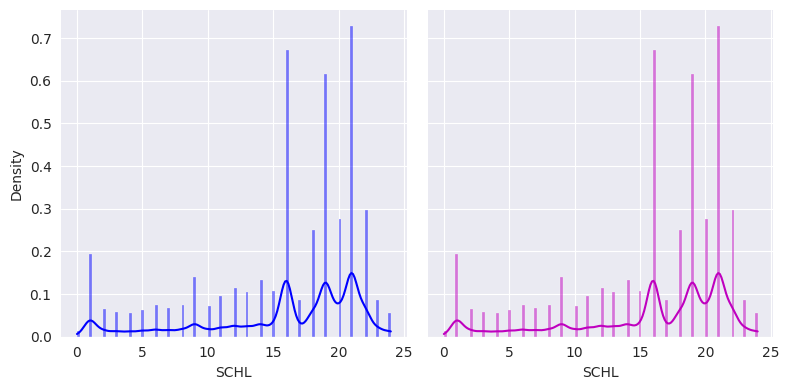





 ###############  Impute SCHL column with impute-by-mean technique  ###############
Impute values:  {'SCHL': 15.76259173785123}
Number of nulls in SCHL column in the corrupted dataframe:  10319
Number of nulls in SCHL column in the imputed dataframe:  0


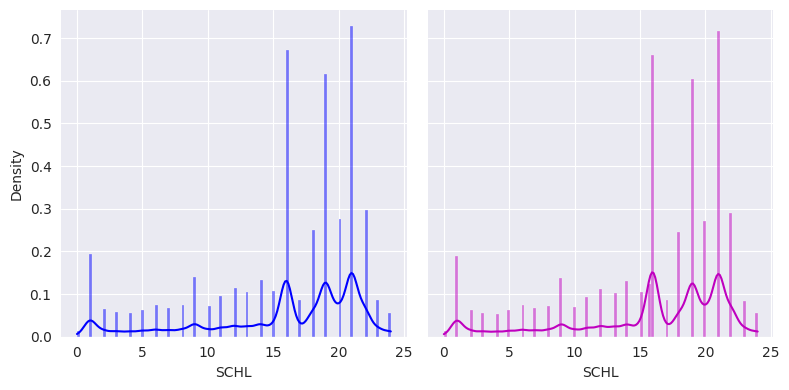





 ###############  Impute SCHL column with impute-by-mean-trimmed technique  ###############
Impute values:  {'SCHL': 16.608741720043476}
Number of nulls in SCHL column in the corrupted dataframe:  10319
Number of nulls in SCHL column in the imputed dataframe:  0


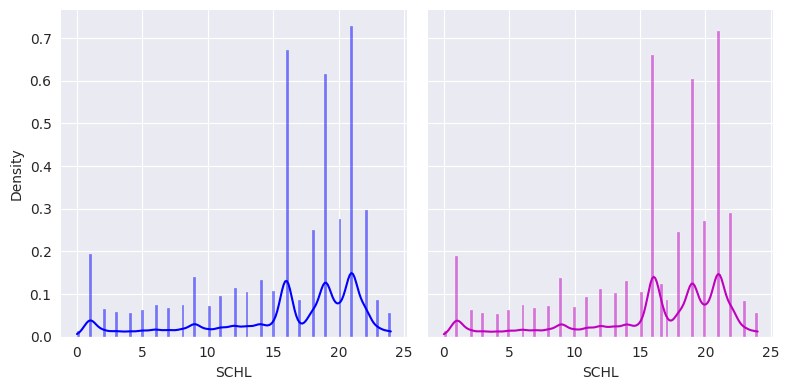





 ###############  Impute SCHL column with impute-by-median technique  ###############
Impute values:  {'SCHL': 18.0}
Number of nulls in SCHL column in the corrupted dataframe:  10319
Number of nulls in SCHL column in the imputed dataframe:  0


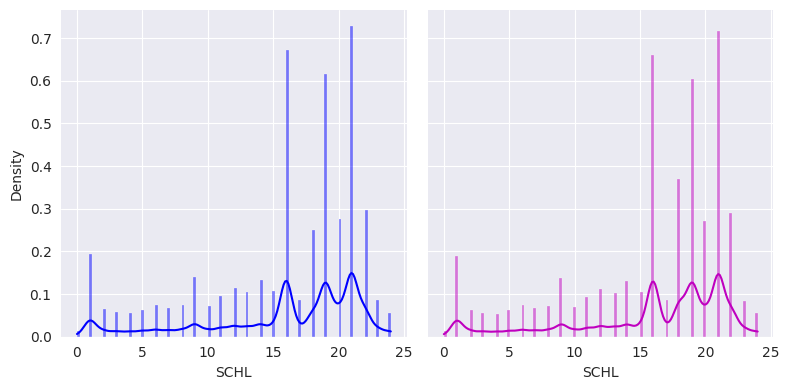





 ###############  Impute SCHL column with impute-by-median-trimmed technique  ###############
Impute values:  {'SCHL': 18.0}
Number of nulls in SCHL column in the corrupted dataframe:  10319
Number of nulls in SCHL column in the imputed dataframe:  0


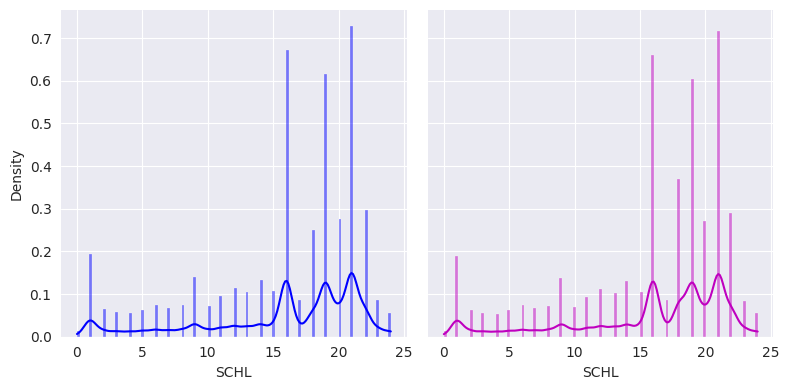

In [113]:
# TODO: round mean
imputed_data_dict_SCHL = impute_with_all_techniques(corrupted_data_SCHL, target_column="SCHL", column_type="numerical")

#### ESP Column





 ###############  Impute ESP column with drop-column technique  ###############




 ###############  Impute ESP column with drop-rows technique  ###############
Number of nulls in ESP column in the corrupted dataframe:  270644
Number of nulls in ESP column in the imputed dataframe:  0


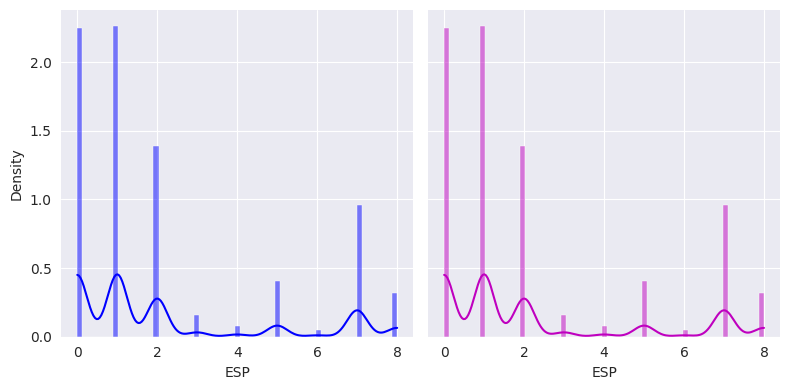





 ###############  Impute ESP column with impute-by-mode technique  ###############
Impute values:  {'ESP': 1.0}
Number of nulls in ESP column in the corrupted dataframe:  270644
Number of nulls in ESP column in the imputed dataframe:  0


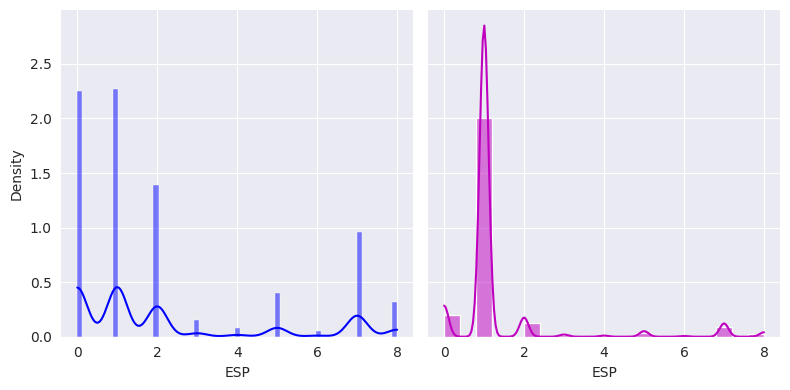





 ###############  Impute ESP column with impute-by-mode-trimmed technique  ###############
Impute values:  {'ESP': 1.0}
Number of nulls in ESP column in the corrupted dataframe:  270644
Number of nulls in ESP column in the imputed dataframe:  0


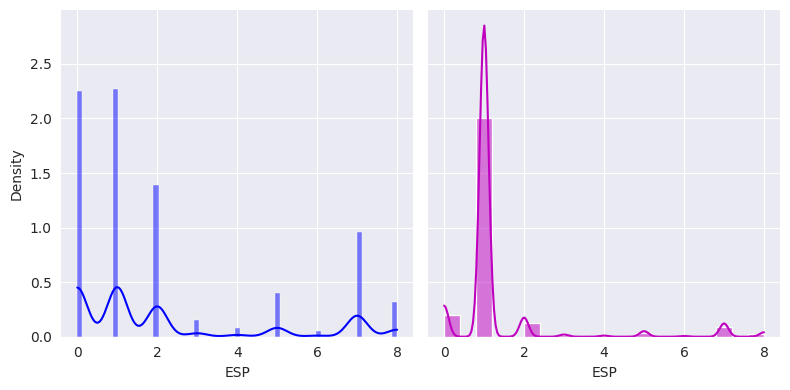

In [114]:
imputed_data_dict_ESP = impute_with_all_techniques(corrupted_data_ESP, target_column="ESP", column_type="categorical")

#### MIG Column





 ###############  Impute MIG column with drop-column technique  ###############




 ###############  Impute MIG column with drop-rows technique  ###############
Number of nulls in MIG column in the corrupted dataframe:  3331
Number of nulls in MIG column in the imputed dataframe:  0


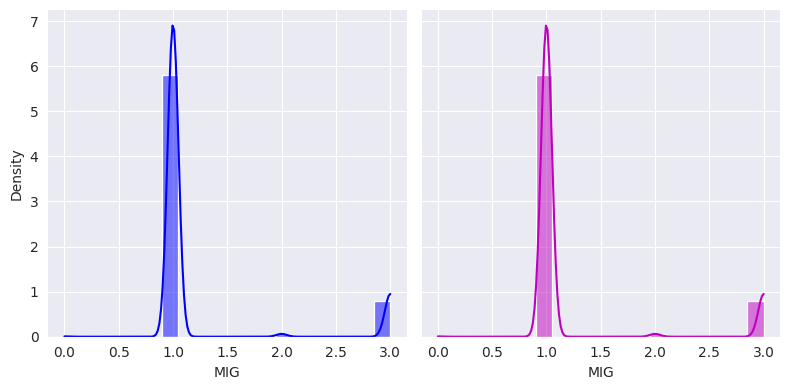





 ###############  Impute MIG column with impute-by-mode technique  ###############
Impute values:  {'MIG': 1.0}
Number of nulls in MIG column in the corrupted dataframe:  3331
Number of nulls in MIG column in the imputed dataframe:  0


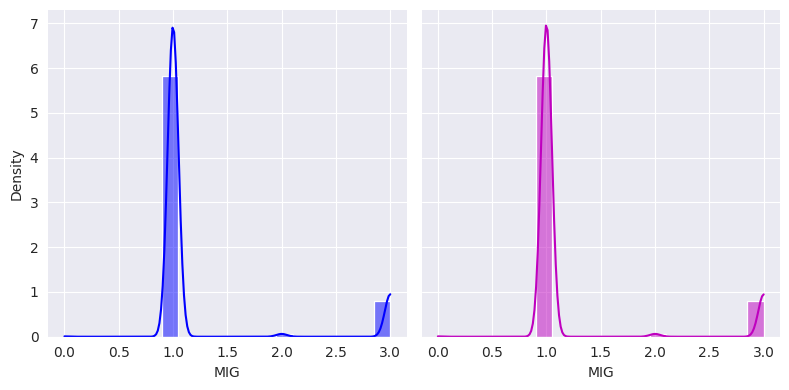





 ###############  Impute MIG column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MIG': 1.0}
Number of nulls in MIG column in the corrupted dataframe:  3331
Number of nulls in MIG column in the imputed dataframe:  0


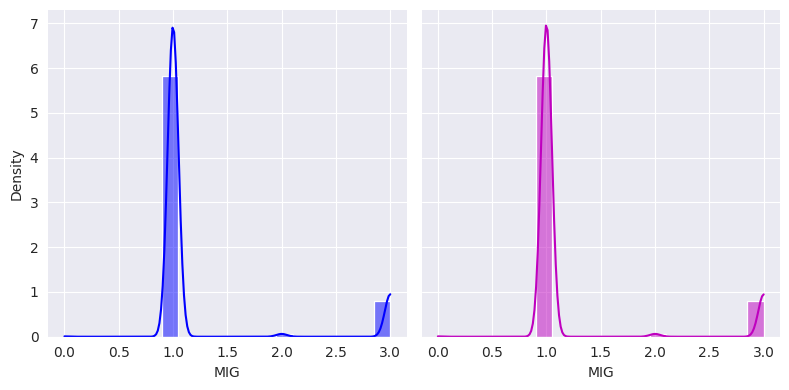

In [115]:
imputed_data_dict_MIG = impute_with_all_techniques(corrupted_data_MIG, target_column="MIG", column_type="categorical")

#### DREM Column





 ###############  Impute DREM column with drop-column technique  ###############




 ###############  Impute DREM column with drop-rows technique  ###############
Number of nulls in DREM column in the corrupted dataframe:  17644
Number of nulls in DREM column in the imputed dataframe:  0


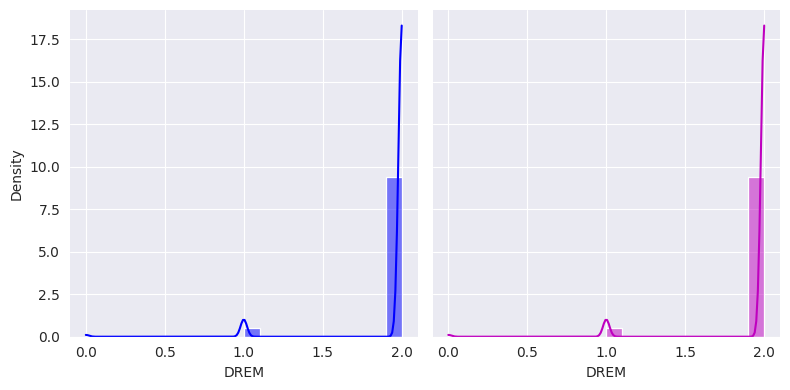





 ###############  Impute DREM column with impute-by-mode technique  ###############
Impute values:  {'DREM': 2.0}
Number of nulls in DREM column in the corrupted dataframe:  17644
Number of nulls in DREM column in the imputed dataframe:  0


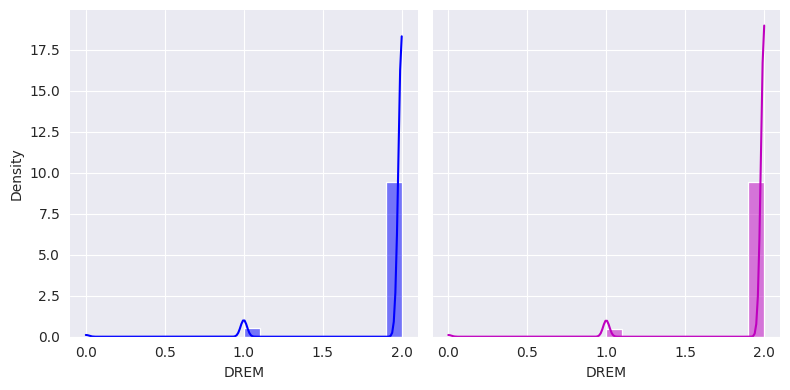





 ###############  Impute DREM column with impute-by-mode-trimmed technique  ###############
Impute values:  {'DREM': 2.0}
Number of nulls in DREM column in the corrupted dataframe:  17644
Number of nulls in DREM column in the imputed dataframe:  0


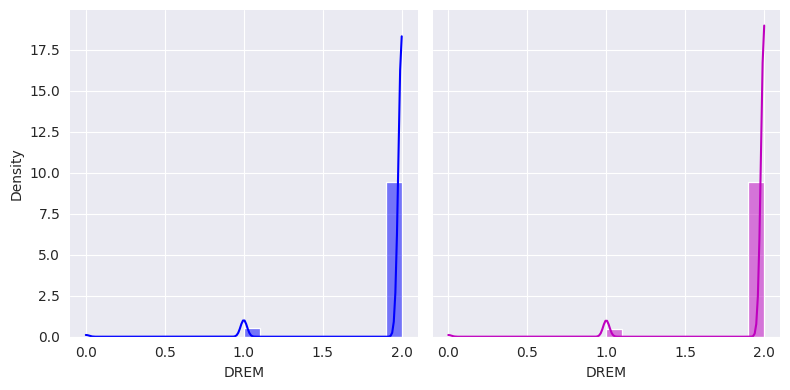

In [116]:
imputed_data_dict_DREM_not_appl = impute_with_all_techniques(corrupted_data_DREM_not_applic, target_column="DREM", column_type="categorical")

### Unknown

#### AGEP Column





 ###############  Impute AGEP column with drop-column technique  ###############




 ###############  Impute AGEP column with drop-rows technique  ###############
Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


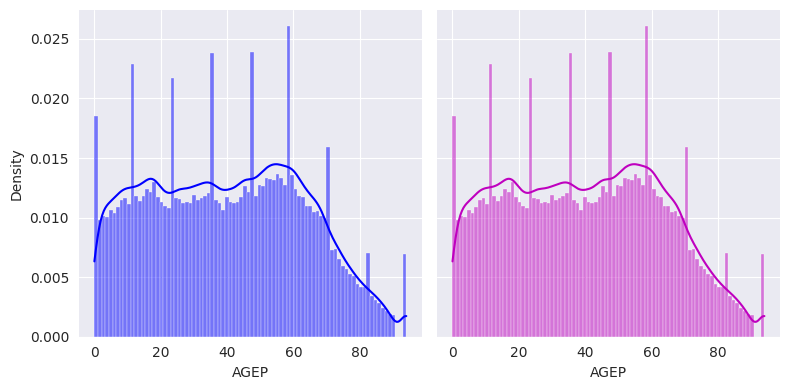





 ###############  Impute AGEP column with impute-by-mean technique  ###############
Impute values:  {'AGEP': 40.145252591183784}
Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


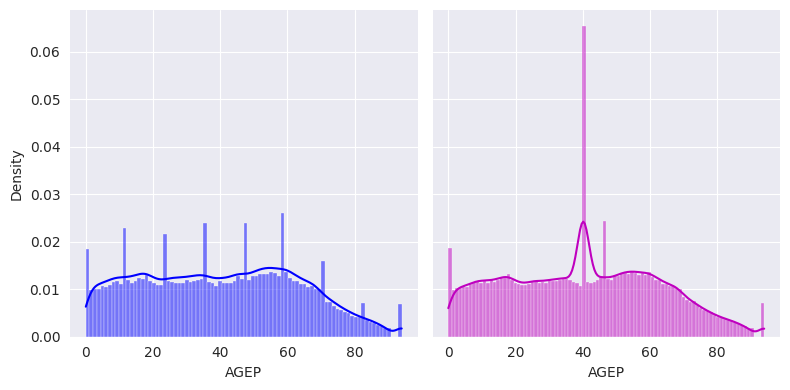





 ###############  Impute AGEP column with impute-by-mean-trimmed technique  ###############
Impute values:  {'AGEP': 39.70322489889221}
Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


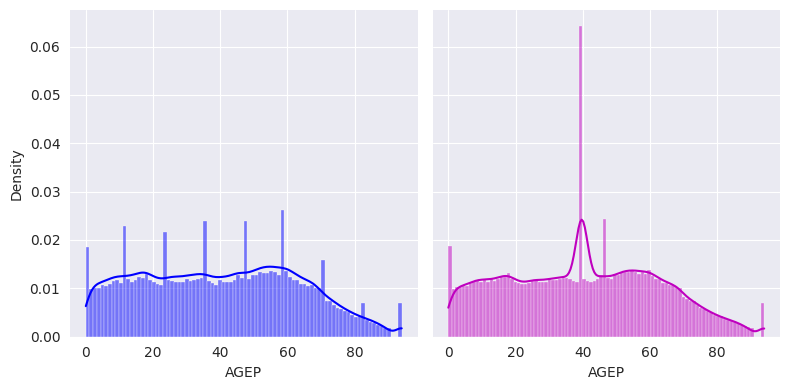





 ###############  Impute AGEP column with impute-by-median technique  ###############
Impute values:  {'AGEP': 40.0}
Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


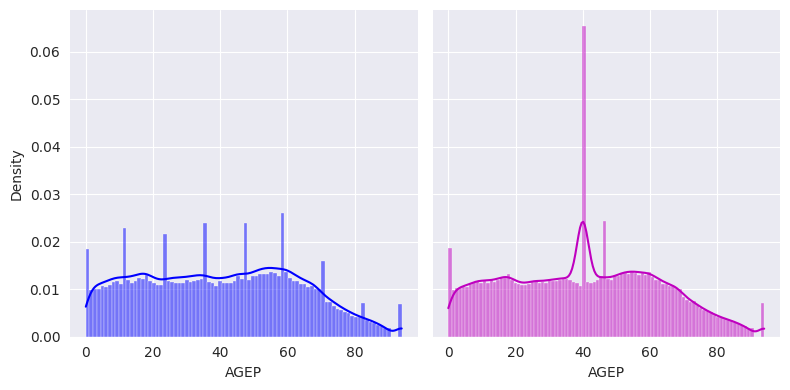





 ###############  Impute AGEP column with impute-by-median-trimmed technique  ###############
Impute values:  {'AGEP': 40.0}
Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


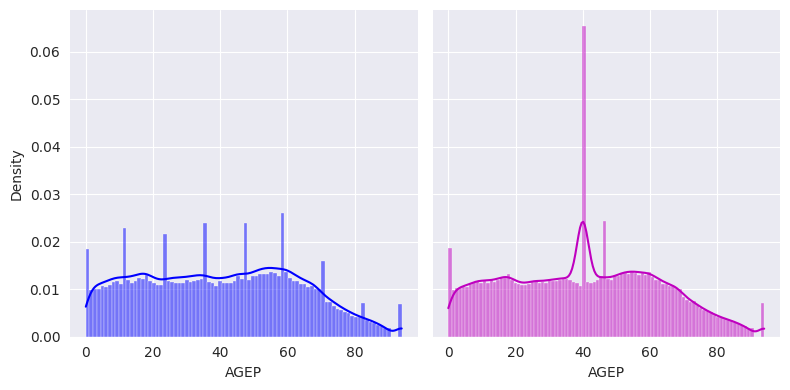

In [117]:
imputed_data_dict_AGEP = impute_with_all_techniques(corrupted_data_AGEP, target_column="AGEP", column_type="numerical")

#### NATIVITY Column





 ###############  Impute NATIVITY column with drop-column technique  ###############




 ###############  Impute NATIVITY column with drop-rows technique  ###############
Number of nulls in NATIVITY column in the corrupted dataframe:  12480
Number of nulls in NATIVITY column in the imputed dataframe:  0


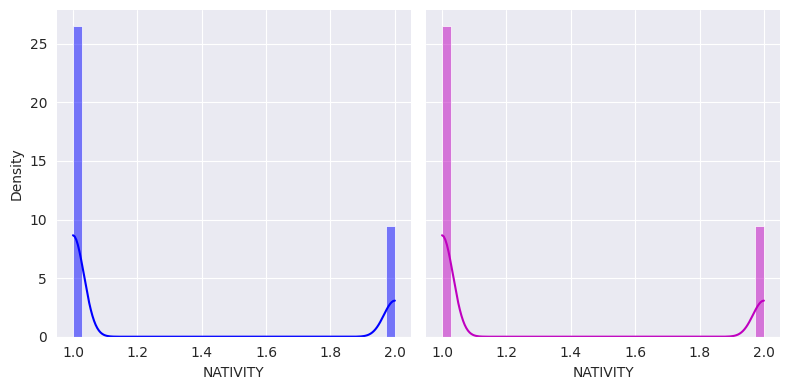





 ###############  Impute NATIVITY column with impute-by-mode technique  ###############
Impute values:  {'NATIVITY': 1.0}
Number of nulls in NATIVITY column in the corrupted dataframe:  12480
Number of nulls in NATIVITY column in the imputed dataframe:  0


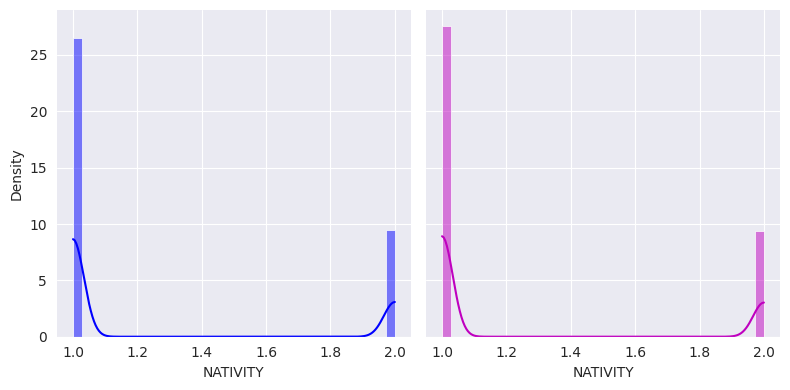





 ###############  Impute NATIVITY column with impute-by-mode-trimmed technique  ###############
Impute values:  {'NATIVITY': 1.0}
Number of nulls in NATIVITY column in the corrupted dataframe:  12480
Number of nulls in NATIVITY column in the imputed dataframe:  0


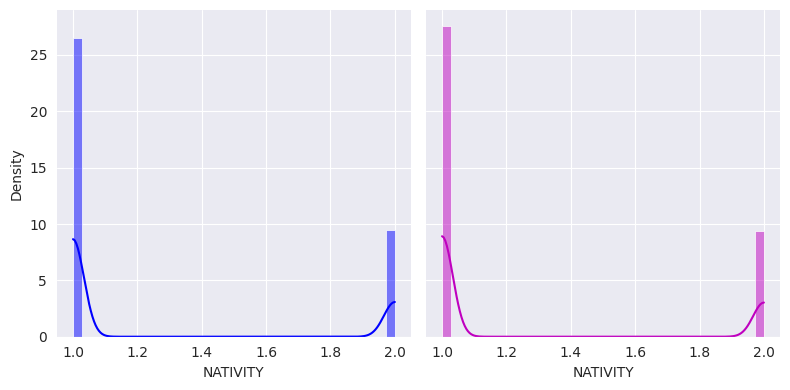

In [118]:
imputed_data_dict_NATIVITY = impute_with_all_techniques(corrupted_data_NATIVITY, target_column="NATIVITY", column_type="categorical")

### Avoided

#### DIS Column





 ###############  Impute DIS column with drop-column technique  ###############




 ###############  Impute DIS column with drop-rows technique  ###############
Number of nulls in DIS column in the corrupted dataframe:  43038
Number of nulls in DIS column in the imputed dataframe:  0


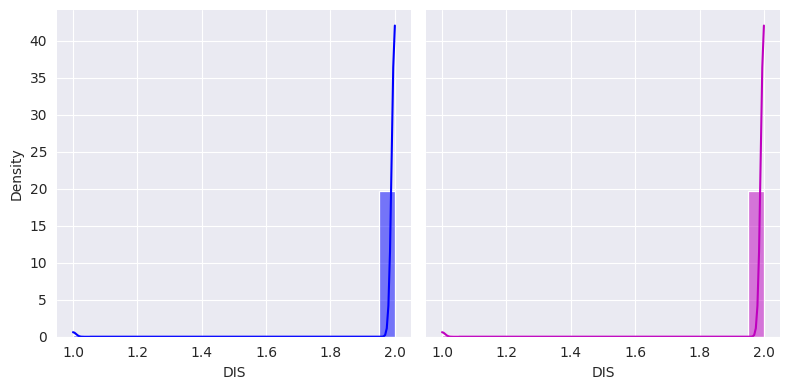





 ###############  Impute DIS column with impute-by-mode technique  ###############
Impute values:  {'DIS': 2.0}
Number of nulls in DIS column in the corrupted dataframe:  43038
Number of nulls in DIS column in the imputed dataframe:  0


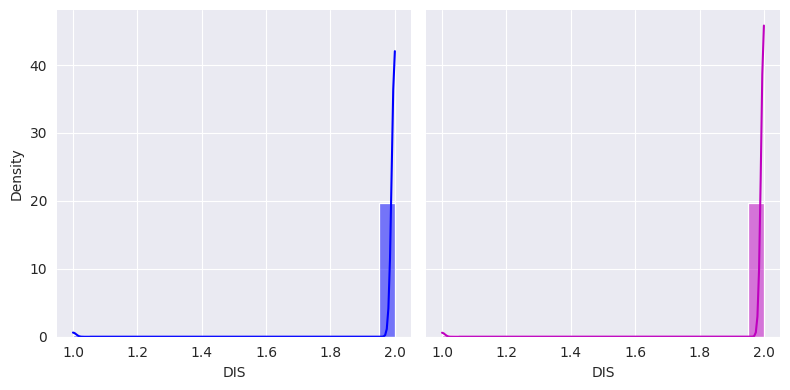





 ###############  Impute DIS column with impute-by-mode-trimmed technique  ###############
Impute values:  {'DIS': 2.0}
Number of nulls in DIS column in the corrupted dataframe:  43038
Number of nulls in DIS column in the imputed dataframe:  0


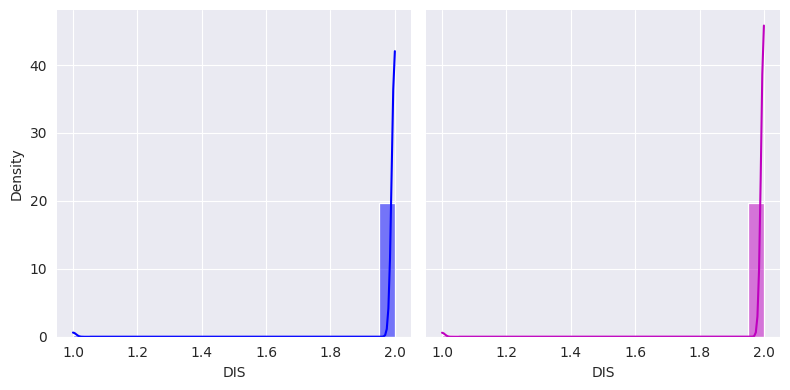

In [119]:
imputed_data_dict_DIS = impute_with_all_techniques(corrupted_data_DIS, target_column="DIS", column_type="categorical")

#### DEAR Column





 ###############  Impute DEAR column with drop-column technique  ###############




 ###############  Impute DEAR column with drop-rows technique  ###############
Number of nulls in DEAR column in the corrupted dataframe:  12060
Number of nulls in DEAR column in the imputed dataframe:  0


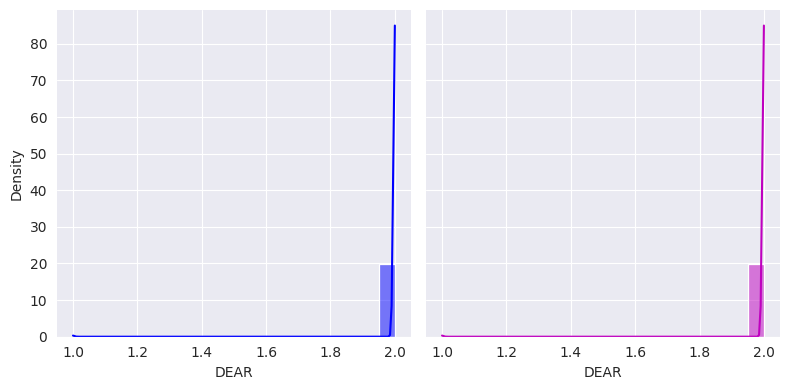





 ###############  Impute DEAR column with impute-by-mode technique  ###############
Impute values:  {'DEAR': 2.0}
Number of nulls in DEAR column in the corrupted dataframe:  12060
Number of nulls in DEAR column in the imputed dataframe:  0


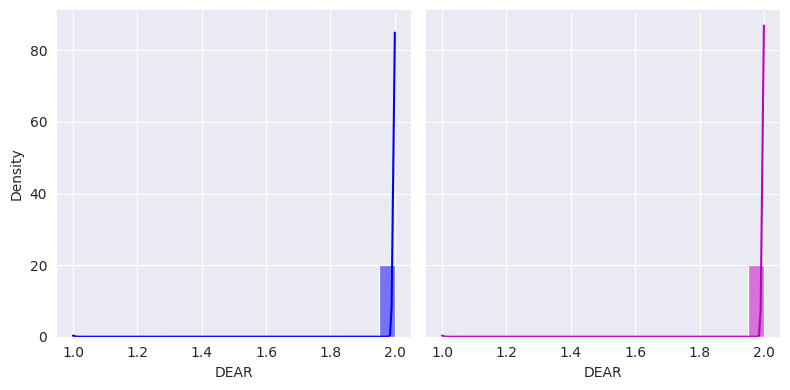





 ###############  Impute DEAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'DEAR': 2.0}
Number of nulls in DEAR column in the corrupted dataframe:  12060
Number of nulls in DEAR column in the imputed dataframe:  0


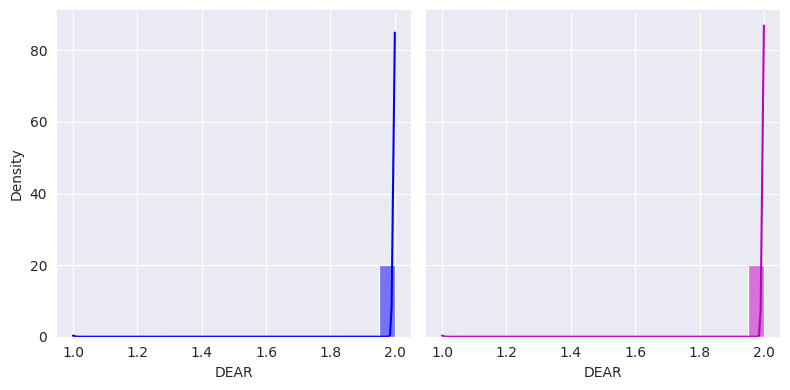

In [120]:
imputed_data_dict_DEAR = impute_with_all_techniques(corrupted_data_DEAR, target_column="DEAR", column_type="categorical")

#### DEYE Column





 ###############  Impute DEYE column with drop-column technique  ###############




 ###############  Impute DEYE column with drop-rows technique  ###############
Number of nulls in DEYE column in the corrupted dataframe:  7896
Number of nulls in DEYE column in the imputed dataframe:  0


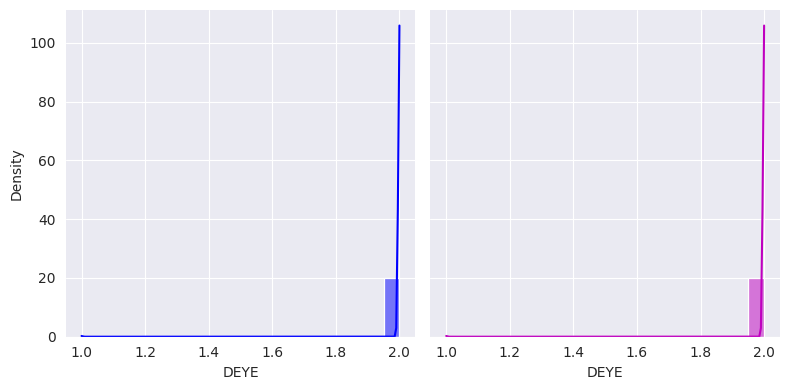





 ###############  Impute DEYE column with impute-by-mode technique  ###############
Impute values:  {'DEYE': 2.0}
Number of nulls in DEYE column in the corrupted dataframe:  7896
Number of nulls in DEYE column in the imputed dataframe:  0


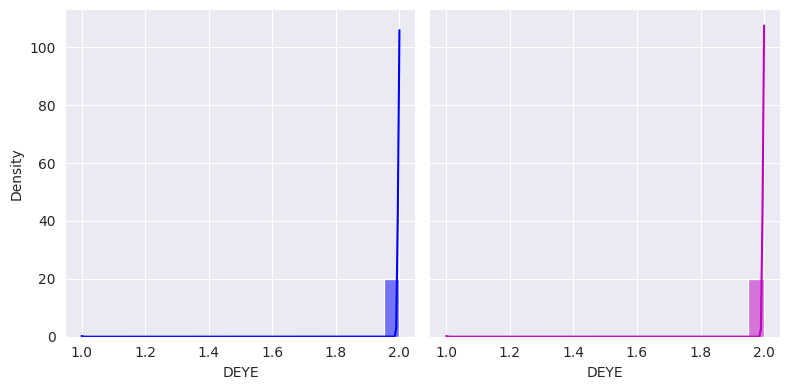





 ###############  Impute DEYE column with impute-by-mode-trimmed technique  ###############
Impute values:  {'DEYE': 2.0}
Number of nulls in DEYE column in the corrupted dataframe:  7896
Number of nulls in DEYE column in the imputed dataframe:  0


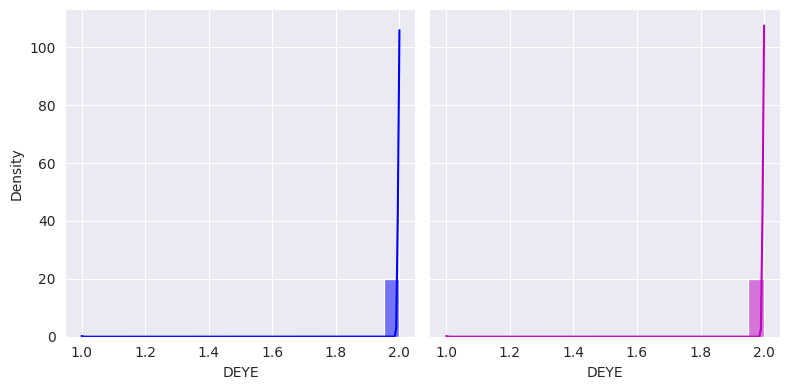

In [121]:
imputed_data_dict_DEYE = impute_with_all_techniques(corrupted_data_DEYE, target_column="DEYE", column_type="categorical")

#### DREM Column





 ###############  Impute DREM column with drop-column technique  ###############




 ###############  Impute DREM column with drop-rows technique  ###############
Number of nulls in DREM column in the corrupted dataframe:  16881
Number of nulls in DREM column in the imputed dataframe:  0


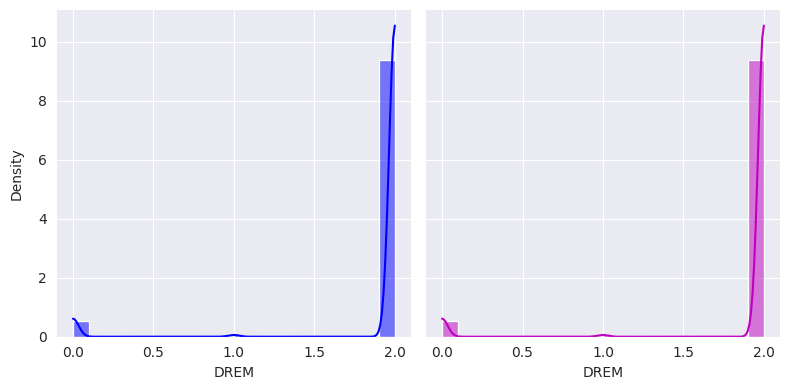





 ###############  Impute DREM column with impute-by-mode technique  ###############
Impute values:  {'DREM': 2.0}
Number of nulls in DREM column in the corrupted dataframe:  16881
Number of nulls in DREM column in the imputed dataframe:  0


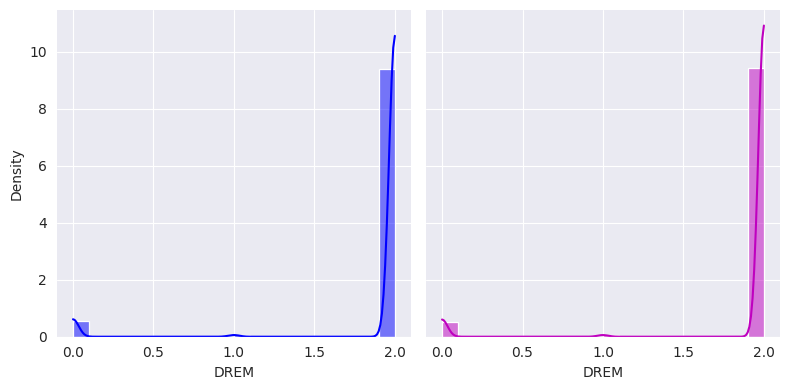





 ###############  Impute DREM column with impute-by-mode-trimmed technique  ###############
Impute values:  {'DREM': 2.0}
Number of nulls in DREM column in the corrupted dataframe:  16881
Number of nulls in DREM column in the imputed dataframe:  0


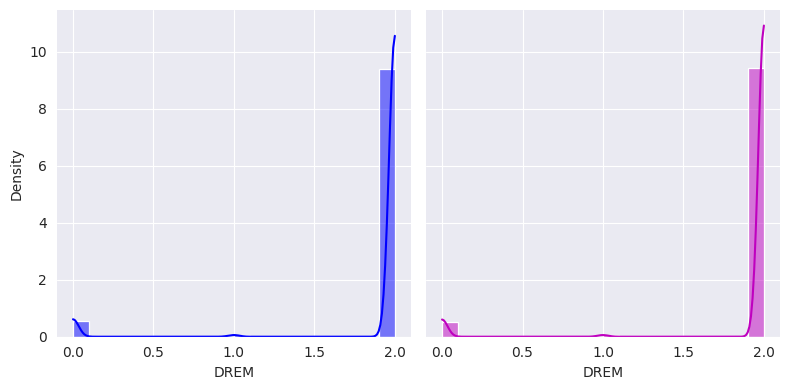

In [122]:
imputed_data_dict_DREM_avoided = impute_with_all_techniques(corrupted_data_DREM_avoided, target_column="DREM", column_type="categorical")

### Special





 ###############  Impute SEX column with drop-column technique  ###############




 ###############  Impute SEX column with drop-rows technique  ###############
Number of nulls in SEX column in the corrupted dataframe:  20416
Number of nulls in SEX column in the imputed dataframe:  0


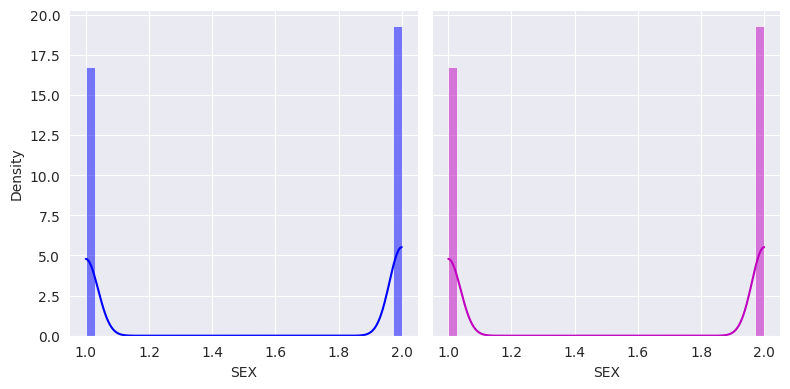





 ###############  Impute SEX column with impute-by-mode technique  ###############
Impute values:  {'SEX': 2.0}
Number of nulls in SEX column in the corrupted dataframe:  20416
Number of nulls in SEX column in the imputed dataframe:  0


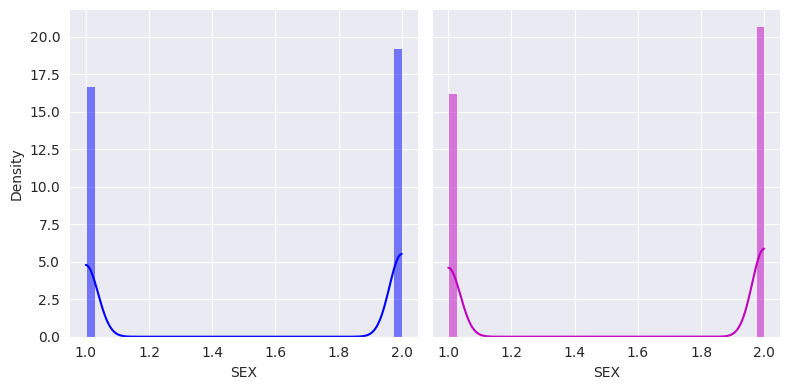





 ###############  Impute SEX column with impute-by-mode-trimmed technique  ###############
Impute values:  {'SEX': 2.0}
Number of nulls in SEX column in the corrupted dataframe:  20416
Number of nulls in SEX column in the imputed dataframe:  0


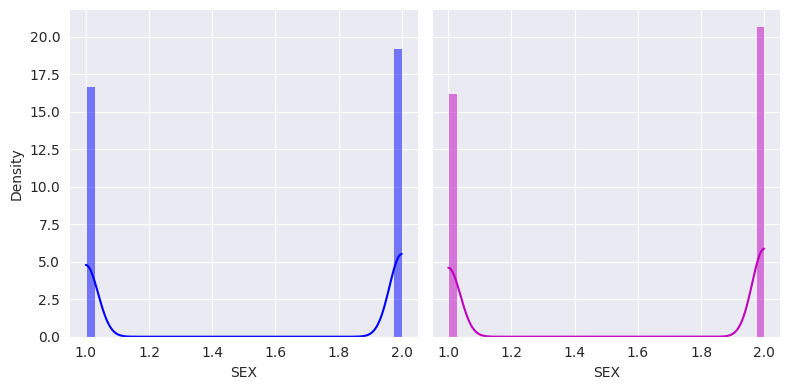

In [123]:
imputed_data_dict_SEX = impute_with_all_techniques(corrupted_data_SEX, target_column="SEX", column_type="categorical")





 ###############  Impute RAC1P column with drop-column technique  ###############




 ###############  Impute RAC1P column with drop-rows technique  ###############
Number of nulls in RAC1P column in the corrupted dataframe:  16180
Number of nulls in RAC1P column in the imputed dataframe:  0


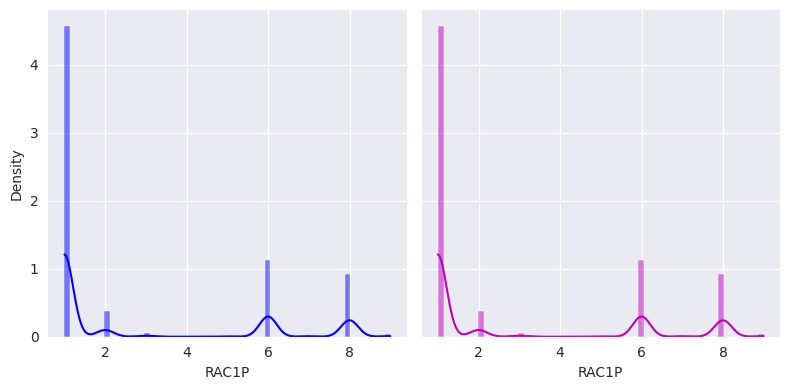





 ###############  Impute RAC1P column with impute-by-mode technique  ###############
Impute values:  {'RAC1P': 1.0}
Number of nulls in RAC1P column in the corrupted dataframe:  16180
Number of nulls in RAC1P column in the imputed dataframe:  0


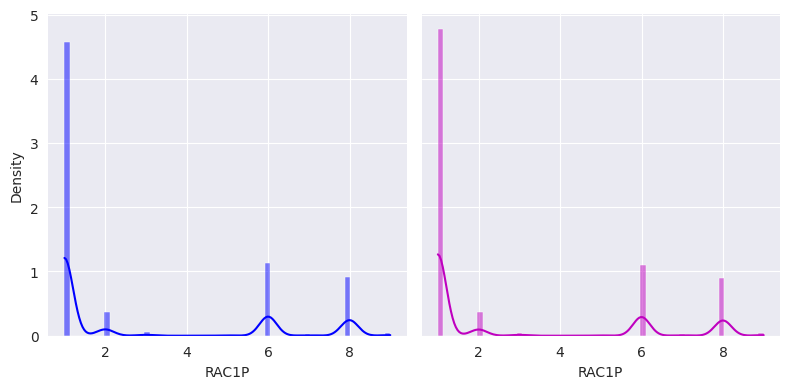





 ###############  Impute RAC1P column with impute-by-mode-trimmed technique  ###############
Impute values:  {'RAC1P': 1.0}
Number of nulls in RAC1P column in the corrupted dataframe:  16180
Number of nulls in RAC1P column in the imputed dataframe:  0


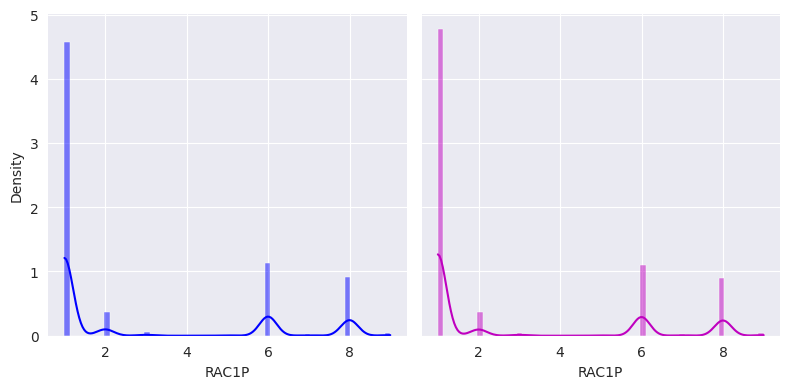

In [124]:
imputed_data_dict_RAC1P = impute_with_all_techniques(corrupted_data_RAC1P, target_column="RAC1P", column_type="categorical")

### Check Prediction Technique

Number of nulls in MAR column in the corrupted dataframe:  47040
Number of nulls in MAR column in the imputed dataframe:  0


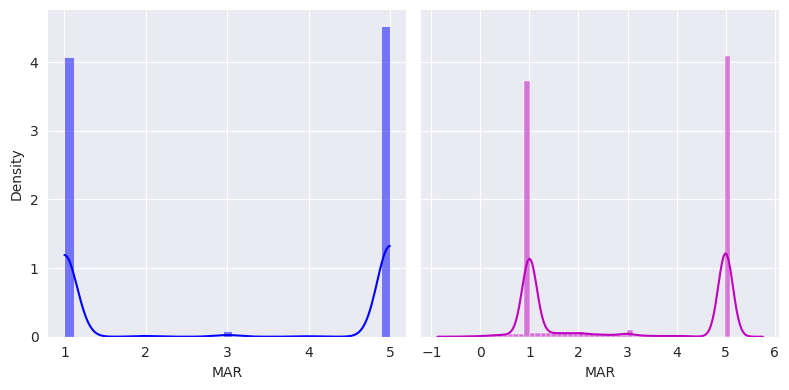

In [125]:
how_to = "predict-by-sklearn"
predicted_data_MAR = handle_df_nulls(corrupted_data_MAR, how_to, column_names=['MAR'])
imputed_nulls_analysis(predicted_data_MAR, corrupted_data_MAR, target_col="MAR")

Number of nulls in AGEP column in the corrupted dataframe:  20599
Number of nulls in AGEP column in the imputed dataframe:  0


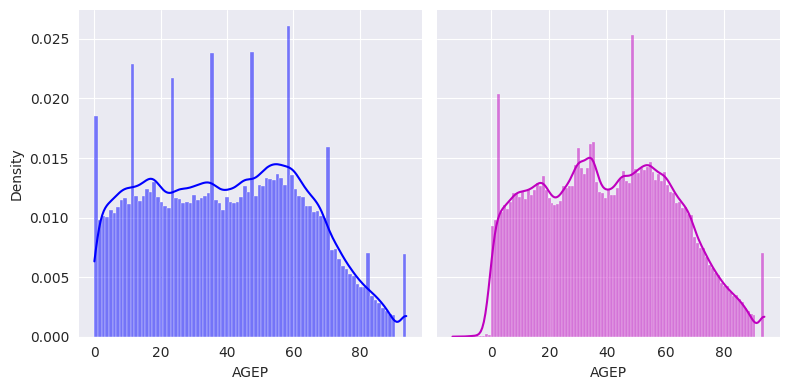

In [126]:
how_to = "predict-by-sklearn"
predicted_data_AGEP = handle_df_nulls(corrupted_data_AGEP, how_to, column_names=['AGEP'])
imputed_nulls_analysis(predicted_data_AGEP, corrupted_data_AGEP, target_col="AGEP")

Number of nulls in MIG column in the corrupted dataframe:  3331
Number of nulls in MIG column in the imputed dataframe:  0


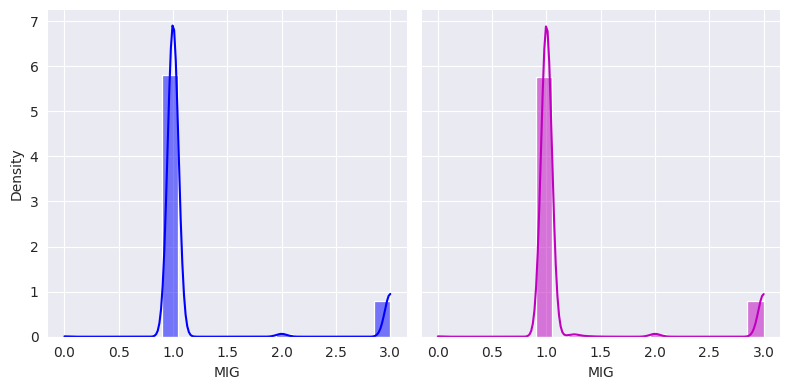

In [127]:
how_to = "predict-by-sklearn"
predicted_data_MIG = handle_df_nulls(corrupted_data_MIG, how_to, column_names=['MIG'])
imputed_nulls_analysis(predicted_data_MIG, corrupted_data_MIG, target_col="MIG")